# Introduction to NLP

Greg Strabel

## Agenda

1. Natural Language Processing - Motivating Tasks
2. Classical NLP
    - Processing text for machine learning
    - Text Classification
    - Topic Modeling
3. Modern NLP - State of the Art models using Transformers

## Natural Language Processing

Natural Language Processing is a field combining linguistics and computer science to analyze natural language data and perform various tasks.

NLP is a broad topic that covers many different tasks. Common tasks include:

1. Text Classification - Predict the topic of a news article from a predefined set of topics.
2. Named Entity Recognition - If "apple" is used in a sentence does it refer to fruit or a company?
3. Question Answering - Given a context text, answer a question about it. This can take the form of either *extractive* question answering (highlighting a span of the input text that contains the answer) or *abstractive* question answering (generating a freeform answer).
4. Text Summarization - Produce a summary of a given text.
5. Textual Entailment - Given a premise and hypothesis determine if the hypothesis follows from the premise.
6. Translation - Translate English to Spanish.
7. Text Generation - Given a prompt, write a story.
8. Dialogue State Tracking - Given a conversation, record key facts about it.
9. Topic modeling - Given a corpus of texts, discover common topics.

## Setting up Google Colab runtime

In [1]:
# Set up Google Colab runtime
import sys
import warnings
warnings.filterwarnings("ignore") # stop warnings for the sake of presentation
if "google.colab" in sys.modules:
    print("Setting up Google Colab... ")
    !git clone https://github.com/Strabes/Intro-to-NLP.git intro-to-nlp
    %cd intro-to-nlp
    from install import install_requirements
    install_requirements()
    from IPython.display import HTML, display

    def set_css():
        display(HTML('''
          <style>
          pre {
            white-space: pre-wrap;
          }
          </style>
          '''))
    get_ipython().events.register('pre_run_cell', set_css)

## 20 Newsgroups Dataset

The 20 Newsgroups dataset is a classic dataset in NLP for document classification experiments. It consists of ~20K newsgroup posts that are classified into 20 topics.

In [2]:
from sklearn.datasets import fetch_20newsgroups

d_train = fetch_20newsgroups(
    subset="train",
    remove=('headers','footers','quotes'),
    shuffle=True,
    random_state=42)

d_test = fetch_20newsgroups(
    subset="test",
    remove=('headers','footers','quotes'),
    shuffle=True,
    random_state=42)

print("The topics in the dataset are: " +
  ", ".join([f"'{x}'" for x in d_train["target_names"]]))

The topics in the dataset are: 'alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'


## Example texts form 20 Newsgroups

In [3]:
for text in d_train["data"][:3]:
    print("-"*50)
    print(text.replace("\\"," "))

--------------------------------------------------
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
--------------------------------------------------
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please 

## Tokenization

NLP requires converting natural language documents to numeric representations and performing computations on these representations. The first step to **encoding** documents into numeric representations is breaking the documents down into smaller units via **tokenization**. One obvious method of tokenization is **word tokenization**:

In [4]:
import nltk

example = d_train["data"][0]

def word_tokenize(text):
    x = nltk.word_tokenize(text.replace("\\"," "))
    return x

example_tokenized = word_tokenize(example)

print(example + "\n ==> ")
print(", ".join([f"'{t}'" for t in example_tokenized]))

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
 ==> 
'I', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'I', 'saw', 'the', 'other', 'day', '.', 'It', 'was', 'a', '2-door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s/', 'early', '70s', '.', 'It', 'was', 'called', 'a', 'Bricklin', '.', 'The', 'doors', 'were', 'really', 'small', '.', 'In', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', '.', 'This', 'is', 'all', 'I', 'know', '.',

## Vocabularies

We then create a **vocabulary** that maps tokens to indices:

In [5]:
from itertools import islice
dict(islice({j:i for i,j in enumerate(set(example_tokenized))}.items(),10))

{'the': 0,
 'a': 1,
 'early': 2,
 'where': 3,
 'In': 4,
 'enlighten': 5,
 'addition': 6,
 'can': 7,
 'name': 8,
 'separate': 9}

## Building a vocabulary from a corpus

Of course we do not use just a single document to create our vocabulary, but a collection of documents, called a **corpus**. We also need to specify a maximum number of tokens for our vocabulary.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

count_vectorizer = CountVectorizer(
    tokenizer = word_tokenize,
    max_features = 1000, # max number of tokens in our vocabulary
    lowercase = False)

# Train the vocabulary on 1000 example texts
count_vectorizer.fit(d_train["data"][:1000])

print("Here's a subset of our vocabulary:")
dict(islice(count_vectorizer.vocabulary_.items(),10))

Here's a subset of our vocabulary:


{'I': 146,
 'was': 948,
 'wondering': 979,
 'if': 572,
 'anyone': 313,
 'out': 731,
 'there': 893,
 'could': 414,
 'me': 659,
 'on': 718}

## Classical NLP

Many traditional statistical and machine learning models expect data to be in a tabular format where columns correspond to specific features and rows correspond to individual observations (in the case of NLP, each document is treated as an individual observation).

A common method of transforming a corpus of documents into a tabular format is **bag-of-words** where each column in the table represents a given word (token) and the entry in row i, column j is the count of times word j occurs in document i.

In [7]:
pd.DataFrame(
    count_vectorizer.transform(d_train["data"][:1000]).toarray(),
    columns = count_vectorizer.get_feature_names_out().tolist())

,!,#,$,%,&,','','AS,'AX,'d,...,x-Soviet,year,years,yes,yet,you,your,{,|,}
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0,0,0,3,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2,0


## Improved token set

The simple word level tokenization above produces a number of tokens that are unlikely to be informative. Given a fixed maximum number of tokens we can generally produce a more informative set of tokens by:

1. Lowercasing: no reason to produce columns for both "Apple" and "apple"
2. Removing **stopwords**, a list of common tokens such as "the", "a", "this", etc. that are unlikely to add value in the bag of words approach.
3. Reducing morphological inflections:
   - **Stemming** uses heuristic rules to reduce morphological inflections by chopping common suffixes from tokens.
   - **Lemmatization** is a more sophisticated technique that generally uses vocabularies, word context and part-of-speech tagging to infer the correct lemma of a word. Lemmatization tends to be more computationally intensive than stemming.


### Stopwords

In [8]:
import sklearn

ENGLISH_STOP_WORDS = sklearn.feature_extraction._stop_words.ENGLISH_STOP_WORDS

print("Here are the stopwords we'll remove:\n")
print(", ".join(ENGLISH_STOP_WORDS))

Here are the stopwords we'll remove:

namely, cry, either, something, hers, twenty, re, during, was, me, our, being, toward, describe, whence, yours, where, name, seem, towards, alone, have, why, well, should, elsewhere, find, few, much, put, yourselves, former, on, any, both, call, sometimes, herein, forty, out, everywhere, before, beyond, moreover, meanwhile, ours, together, if, four, is, everything, a, whither, whose, yet, again, next, but, its, above, after, go, between, by, others, often, became, these, becomes, anyone, eleven, their, your, nor, do, below, therefore, than, neither, will, wherever, himself, no, some, him, be, those, six, nine, this, give, down, therein, mine, already, to, or, hereafter, latter, third, us, once, ltd, herself, co, bottom, they, twelve, show, every, anything, because, made, though, anyhow, hasnt, at, only, for, last, none, are, been, someone, such, into, whereas, beforehand, due, may, less, sixty, otherwise, were, everyone, who, thick, become, almost,

### Stemming

We'll use the Porter stemmer for word stemming:

In [9]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

stemming_example_words = ["stop","stops","stopping","stopped"]

for word in stemming_example_words:
    print(f"The stem of '{word}' is '{porter_stemmer.stem(word)}'")

The stem of 'stop' is 'stop'
The stem of 'stops' is 'stop'
The stem of 'stopping' is 'stop'
The stem of 'stopped' is 'stop'


## An improved tokenizer

In [10]:
import re
import sklearn

def word_tokenize(text, stopwords = ENGLISH_STOP_WORDS):
    """Tokenize a string by:
    1. Tokenize words
    2. Filtering out tokens that don't contain at least
       two consecutive alpha-numeric characters or start with
       and apostrophe.
    3. Lowercase characters
    4. Remove stopwords.
    5. Remove repeated words.
    4. Apply the Porter stemmer
    """
    x = nltk.word_tokenize(text.replace("\\"," "))
    x = [t for t in x if re.search("[A-Za-z0-9]{2,}",t) and not re.match("'.*",t)]
    x = [t.lower() for t in x] # lowercase
    x = [t for t in x if t not in stopwords]
    x = [x[i] for i in range(len(x)) if i==0 or x[i] != x[i-1]]
    return [porter_stemmer.stem(t) for t in x]

count_vectorizer = CountVectorizer(
    #tokenizer=word_tokenize,
    analyzer=word_tokenize,
    max_features=100
    )

count_vectorizer.fit(d_train["data"][:1000])

pd.DataFrame(count_vectorizer.transform(d_train["data"][:1000]).toarray(),
columns = count_vectorizer.get_feature_names_out().tolist())

,applic,argument,armenian,ask,believ,better,ca,call,car,case,...,tri,true,understand,use,want,way,window,word,work,year
0,0,0,0,0,0,0,0,1,4,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,0,0,0,0,0


## N-grams

One of the primary downsides of bag-of-words is that it loses all information contained in the order of the tokens. For example, both "Dog bites man" and "Man bites dog" produce the same bag-of-words representation. One method for partially overcoming this shortcoming is to use **n-grams**; the creation of a new token by combining `n` consecutive tokens

In [11]:
import random
random.seed(1)

count_vectorizer = CountVectorizer(
    tokenizer=word_tokenize,
    max_features=2000,
    ngram_range=(1,4), # n-grams from 1-4
    max_df = 0.5, # tokens occurring in a higher proportion of documents than this are left out
    min_df = 0.0001 # tokens occurring in a lower proportion of documents than this are left out
    )

count_vectorizer.fit(d_train["data"])

random_sample_n_grams = random.sample(
    [i for i in count_vectorizer.get_feature_names_out() if re.search(" ",i)],10)

print("Some example n-grams for n>=2 \n")

print(", ".join([f"'{t}'" for t in random_sample_n_grams]))


Some example n-grams for n>=2 

'doe know', 'serial number', 'avail anonym ftp', 'hard disk', 'disk drive', 'new york', 'make sure', 'ms. myer', 'long time', 'ftp site'


## Text Classification with Logistic Regression

Finally we can use our matrix of vectorized texts to fit a logistic regression model for topic classification. We pipe the output of our `CountVectorizer` through a `TfidfTransformer` (Term Frequency Inverse Document Frequency) object that normalizes document-level token counts by corpus-level token frequency. This is then piped into a logistic regression classifier. We fit our pipeline on the training data.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("count_vectorizer", count_vectorizer),
    ("tfidf_transformer", TfidfTransformer()),
    ("logistic_reg", LogisticRegression(multi_class='multinomial'))])

pipe.fit(d_train["data"],d_train["target"])

Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_df=0.5, max_features=2000, min_df=0.0001,
                                 ngram_range=(1, 4),
                                 tokenizer=<function word_tokenize at 0x0000020EDDFB0D30>)),
                ('tfidf_transformer', TfidfTransformer()),
                ('logistic_reg',
                 LogisticRegression(multi_class='multinomial'))])

## Model evaluation

We evaluate the model using precision and recall. For a given topic:

  - **Precision** is the number of times we predicted that topic correctly divided by the number of times we predicted that topic (both correctly and incorrectly).

  - **Recall** is the number of times we predicted that topic correctly divided by the number of actual cases of the topic.

A model that just guessed randomly and uniformly on our dataset would have both precision and recall close to 0.05. Our simple model is already much better than that:

In [13]:
from sklearn.metrics import classification_report

test_preds = pipe.predict(d_test["data"])

print(
    f"Classification report for classifier:\n" +
    f"""{classification_report(
        d_test['target'], test_preds,
        target_names=d_test['target_names'])}\n""")

Classification report for classifier:
                          precision    recall  f1-score   support

             alt.atheism       0.41      0.42      0.41       319
           comp.graphics       0.56      0.59      0.57       389
 comp.os.ms-windows.misc       0.57      0.55      0.56       394
comp.sys.ibm.pc.hardware       0.58      0.56      0.57       392
   comp.sys.mac.hardware       0.63      0.56      0.59       385
          comp.windows.x       0.70      0.61      0.65       395
            misc.forsale       0.71      0.74      0.72       390
               rec.autos       0.66      0.62      0.64       396
         rec.motorcycles       0.42      0.70      0.53       398
      rec.sport.baseball       0.72      0.75      0.73       397
        rec.sport.hockey       0.83      0.79      0.81       399
               sci.crypt       0.81      0.63      0.71       396
         sci.electronics       0.48      0.53      0.50       393
                 sci.med       0.68  

## Topic Modeling

In many use cases, labeled training data is limited or not available. It is still possible though to learn about the documents in such a corpus. Topic modeling constructs latent topics from a corpus and represents each text as some combination of these latent topics. 

## Topic Modeling with Latent Dirichlet Allocation

Latent Dirichlet Allocation is one common method of topic modeling.

In [14]:
from sklearn.decomposition import LatentDirichletAllocation

n_components = 20

lda = LatentDirichletAllocation(
    n_components=n_components,
    random_state=0,
)

lda_pipe = Pipeline([
    ("count_vectorizer", count_vectorizer),
    ("tfidf_transformer", TfidfTransformer()),
    ("lda", lda)])

lda_pipe.fit(d_train["data"])

Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_df=0.5, max_features=2000, min_df=0.0001,
                                 ngram_range=(1, 4),
                                 tokenizer=<function word_tokenize at 0x0000020EDDFB0D30>)),
                ('tfidf_transformer', TfidfTransformer()),
                ('lda',
                 LatentDirichletAllocation(n_components=20, random_state=0))])

## Plotting top words for each latent topic

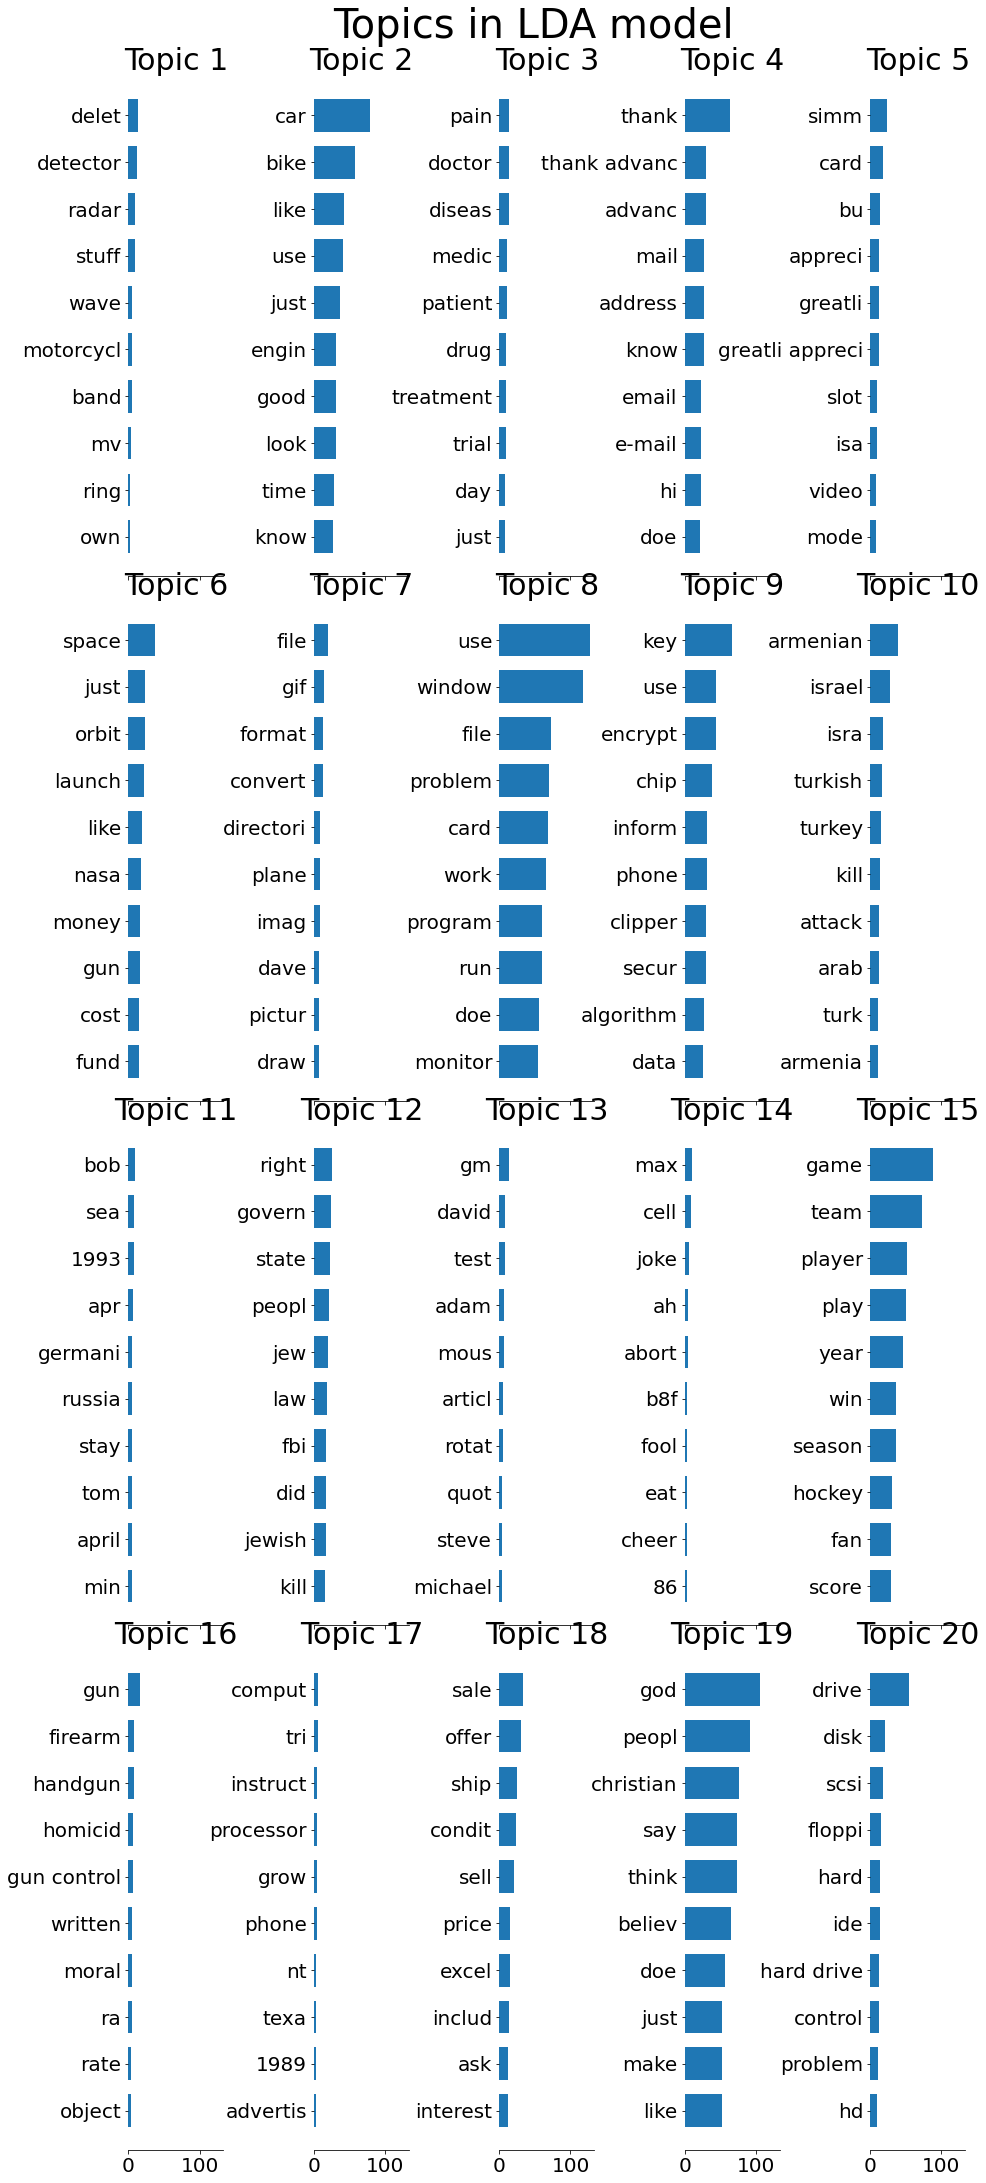

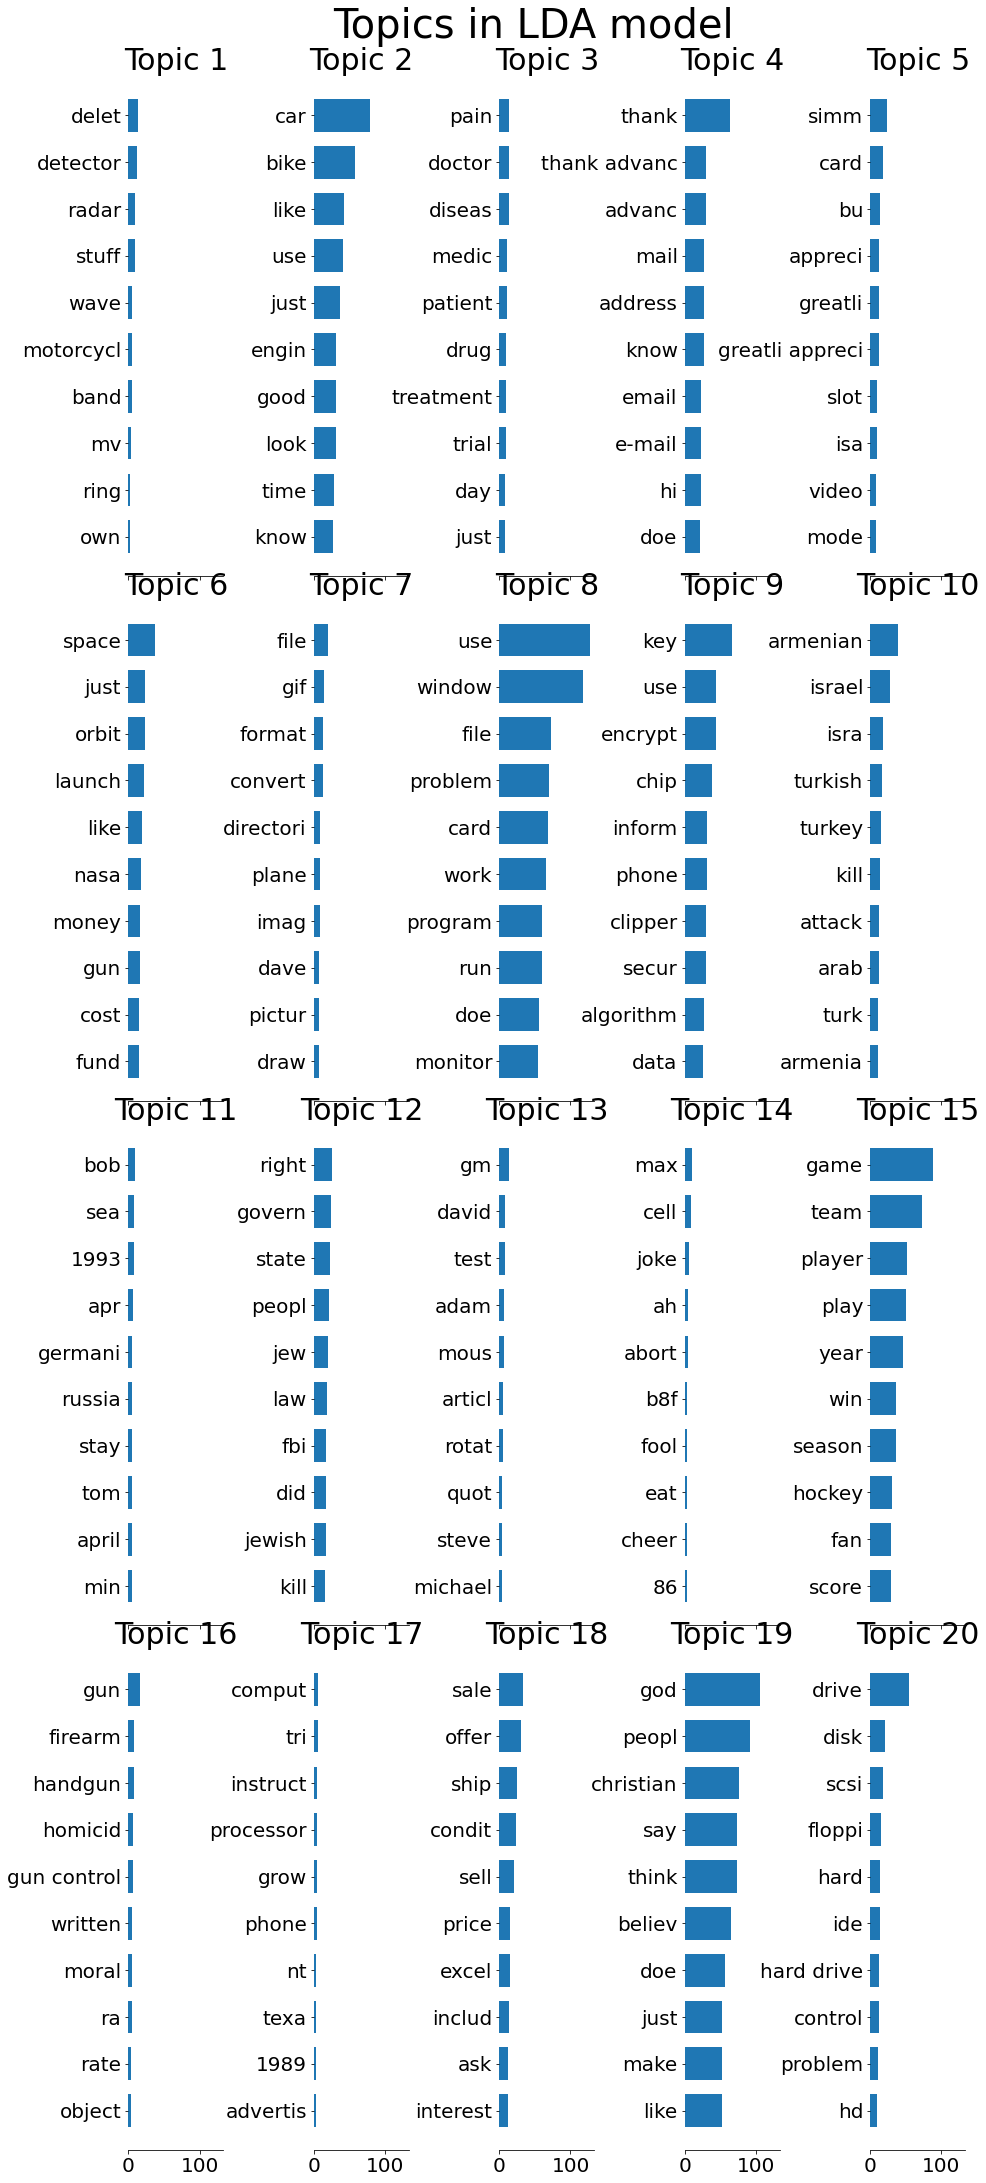

In [15]:
from utils import plot_top_words

n_top_words=10
tf_feature_names = lda_pipe["count_vectorizer"].get_feature_names_out()
plot_top_words(lda_pipe["lda"], tf_feature_names, n_top_words, "Topics in LDA model")

## 20 Newsgroups as a combination of LDA Topics

Topic modeling is unsupervised in that it does not use labels to learn a representation of the data: our LDA model makes no use of the 20 Newsgroup categories themselves. But if the model has learned a useful representation of the corpus, it's likely that the latent topics have some relationship with the newsgroup categories.

Each document is represented as a weighted mixture of latent topics. For each 20 newsgroup category we can take all the documents in the test data for that category and calculate the mean weight for each latent topic. This is what we plot below.

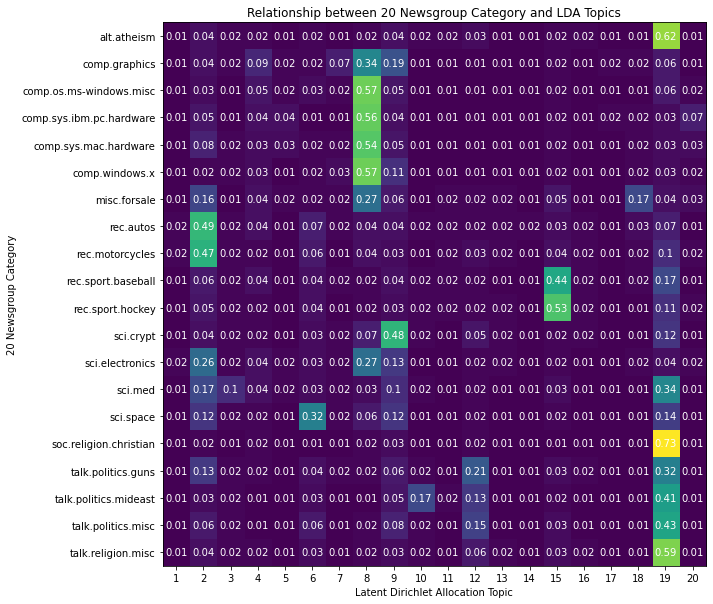

In [16]:
from utils import plot_heatmap

lda_test_preds = lda_pipe.transform(d_test["data"])
        
plot_heatmap(lda_test_preds, d_test["target"], d_test["target_names"]);

## State-of-the-Art NLP with Transformers

All state-of-the-art models in NLP are now a type of deep neural network using a variant of the architecture called a "transformer".

The transformer architecture was originally introduced in the paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) by Vaswani et al. 2017 (Google Brain/Google Research).

![Transformer Architecture](images/transformer_architecture.png)

*Attention is All You Need* was concerned with translation, for instance from English to German or English to French. In the case of English to German, the inputs to the Transformer Encoder are the full sequence of English token indices from a document, $\mathbb{x} = (x_1, x_2, ... , x_n)$. The output of the Transformer Encoder are a corresponding sequence of vectors $\mathbb{z} = (z_1, z_2, ... , z_n)$.

The Transformer Decoder then generates an output sequence $\mathbb{y} = (y_1, y_2, ... , y_m)$ of German token indices one at a time. At each time step the Transformer Decoder takes the Transformer Encoder output $\mathbb{z}$ and the part of $\mathbb{y}$ that it had previously generated ($(y_1, ..., y_k)$ where $k<m$) and produces the next token $y_{k+1}$

The Transformer was trained on several million English-German (or English-French) sentence pairs using backpropogation.

## Transformers take over all of NLP

Since the publication of *Attention is All You Need* transformers have pushed out the performance frontier in all NLP tasks. There are three main branches of the transformer family tree:

- Full transformer: This is the original transformer from *Attention is All You Need*. These models excel at tasks that make use of a reference text and generate a new output text, for instance translation and abstractive summarization.
- Decoder-only transformer: these are good at generating text without a provided reference text. Decoder-only models excel as chat bots and writing stories given a prompt.
- Encoder-only transformer: these excel in any NLP task that does not require generating new text, for instance classification, named entity recognition and extractive question answering and summarization.

### Decoder-only Transformers - GPT

In [Improving Language Understanding by Generative Pre-Training](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf), Radford et al 2018 (OpenAI), used just the Transformer Decoder and introduced a novel two-stage training paradigm:

**Pretraining (Unsupervised)**: Train the model on a large corpus of unlabeled text data (typically scraped from the web). Given a chunk of text as input, the model's objective is to predict the word that came next in the source text. For instance, the model receives the input `["The", "cat", "is", "on", "the"]` and must predict which word came next. Pretraining allows the model to learn general features of the language.

**Fine-tuning (Supervised)**: For a specific task with limited labeled training data, like classification or textual entailment, initialize a similar model architecture using the weights learned from pretraining and continue training for the specific task. This requires some creativity in formatting the input data to the model and attaching an additional output layer that is task-specific.

![GPT Pretraining and Fine-tuning](images/gpt_objectives.png)

Transformer Decoder models excel at tasks requiring text generation, for instance chat bots. The most cited transformer decoder models include:

- OpenAI's GPT, GPT-2, GPT-3 and GPT-Neo
- Google's PaLM and LaMDA

### Encoder-only transformers - BERT 

Even though many languages are written and read left to right, the meaning of words and concepts in sentences flow in both directions. The Transformer Decoder-only models do not take advantage of this bidirectionality. Consider the sentence: "The bat that flew through the night air almost hit the player on deck." If you only saw the first 8 words ("The bat that flew through the night air") you probably have a very different understanding of "bat" than if you saw the full sentence. The correct meaning of the word "bat" in this sentence flows backwords from "the player on deck".

In [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf) (Devlin et al. 2019 - also at Google) took just the Transformer Encoder from *Attention is All You Need* and extended the pretraining/fine-tuning approach to produced models that take advantage of bidirectionality and that achieved state-of-the-art performance.

**Pretraining (Unsupervised)**: Just like in Radford et al., train the model on a large corpus of unlabeled text data. Given a chunk of text as input, the model's objective is to predict randomly masked words. For instance, the model receives the input `["The", "[MASK]", "is", "on", "[MASK]", "mat"]` and must predict which words are under the `"[MASK]"` tokens. The original BERT paper also included another pretraining task, next sentence prediction, in which the model had to predict whether one sentence followed another in a source text. This task is generally dropped in more recent versions of BERT.

**Fine-tuning (Supervised)**: The fine-tuning stage is similar to that in Radford et al.: for each task, initialize a modified architecture with weights learned from pretraining and continue to train the model on labeled data.

## Using Google's PEGASUS full transformer model for abstractive summarization.

Now we'll do an actual demo of [Google's PEGASUS](https://arxiv.org/pdf/1912.08777.pdf) full transformer model to perform abstractive summarization.

Abstractive summarization takes a reference text as input to the transformer encoder and generates a summary using the transformer decoder.

Google provides a trained PEGASUS model in the [Huggingface Model Hub](https://huggingface.co/models). `Huggingface` is an opensource project that provides datasets, pretrained models and software for creating, training and using models across `torch`, `tensorflow` and `JAX`.

In [17]:
from transformers import pipeline, set_seed
from datasets import load_dataset, load_metric
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize

## CNN/Daily Mail Dataset

We'll download the CNN/Daily Mail Dataset from Huggingface. The CNN/Daily Mail dataset is well-suited for abstractive summarization because CNN/Daily Mail themselves provide brief summaries of their articles. 

In [18]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")

print(f"Features: {dataset['train'].column_names}")

Using custom data configuration default
Reusing dataset cnn_dailymail (C:\Users\grego\.cache\huggingface\datasets\cnn_dailymail\default\3.0.0\e6f7373c4552f36af359a1fc84b24352f22070483560e87f524e1730f8cf5539)


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


## Example of Article and Summary

In [19]:
sample_idx = 0
sample = dataset["test"][sample_idx]
print(f"""
Article (total length: {len(sample["article"])}):
""")
print(sample["article"])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (total length: 3612):

(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, spea

In [20]:
# Download Google's PEGASUS model that was fine-tuned on CNN/Daily Mail

pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

### Digression on subword tokenization

Modern transformer models typically use a form of tokenization called subword tokenization rather than the word tokenization that we used before. This allows the model to construct rare words or words that did not occur in the training data from subword pieces rather than treating them as out-of-vocabulary:

In [21]:
encoded = pipe.tokenizer.encode("""
Hello. My name is Greg Strabel
and I'm a data scientist. Supercalifragilisticexpialidocious.
""")

print(f"Encoded text: {', '.join([str(i) for i in encoded])}\n")
decoded = [pipe.tokenizer.decode(i) for i in encoded]
print(f"Decoded text: {', '.join([str(i) for i in decoded])}")

Encoded text: 8087, 107, 600, 442, 117, 8303, 26159, 10539, 111, 125, 131, 208, 114, 335, 9732, 107, 2422, 62955, 40972, 4935, 10855, 39053, 7434, 15398, 35898, 107, 1

Decoded text: Hello, ., My, name, is, Greg, Stra, bel, and, I, ', m, a, data, scientist, ., Super, cali, frag, il, istic, exp, ial, ido, cious, ., </s>


### Summarizing the example article

In [22]:
sample_text = dataset["test"][sample_idx]["article"][:2000]

pipe_out = pipe(sample_text)
summary = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")
print(summary)

The Palestinian Authority officially becomes the 123rd member of the International Criminal Court.
The move gives the court jurisdiction over alleged crimes in Palestinian territories .


## Wrap Up

This has been a very short introduction to Natural Language Processing, touching on only a small subset of NLP:

- Common text preprocessing steps
- Classical NLP with bag-of-words, n-grams and logistic regression
- State-of-the-art NLP with Transformers.

Additional resources:

- [Speech and Language Processing 3rd Edition](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf)
- [Natural Language Processing with Transformers: Building Language Applications with Hugging Face](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246/ref=sr_1_1?keywords=natural+language+processing+with+transformers&qid=1658334866&sprefix=natural+language%2Caps%2C113&sr=8-1) 